In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from PIL import Image

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data.dataset import Dataset
from torch.optim import Adam
from torchvision import datasets, transforms
from torchvision.models import vgg16, efficientnet_b0
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from matplotlib import pyplot as plt

In [2]:
BATCH_SIZE = 64
EPOCH = 50
LR = 0.001  # learning rate

In [3]:
data_root = Path('/content/drive/My Drive//final project/data')
# data_root = Path('../data')  # if use local computer
classes_idx_path = data_root.joinpath('Classes.xlsx')
class_frame = pd.read_excel(classes_idx_path)
class_frame

,Folder Name,Class
0,005.Crested_Auklet,0
1,013.Bobolink,1
2,015.Lazuli_Bunting,2
3,023.Brandt_Cormorant,3
4,040.Olive_sided_Flycatcher,4
5,041.Scissor_tailed_Flycatcher,5
6,067.Anna_Hummingbird,6
7,072.Pomarine_Jaeger,7
8,076.Dark_eyed_Junco,8
9,081.Pied_Kingfisher,9


In [4]:
train_list = []
train_labels = []
valid_list = []
valid_labels = []
test_list = []
test_labels = []
image_root = data_root.joinpath('images')
for class_name in os.listdir(image_root):
    folder_path = image_root.joinpath(class_name)
    if os.path.isdir(folder_path):
        file_names = os.listdir(folder_path)
        num_images = len(file_names)
        num_train = int(np.ceil(0.7 * num_images))
        num_valid = int(np.ceil(0.15 * num_images))
        num_test = num_images - num_train - num_valid
        
        train_samples = random.sample(file_names, num_train)
        valid_samples = random.sample(list(set(file_names) - set(train_samples)), num_valid)
        test_samples = list(set(file_names) - set(train_samples) - set(valid_samples))
        
        train_list.extend([os.path.join(folder_path, file) for file in train_samples])
        valid_list.extend([os.path.join(folder_path, file) for file in valid_samples])
        test_list.extend([os.path.join(folder_path, file) for file in test_samples])

        class_label = class_frame.loc[class_frame.iloc[:, 0] == class_name, 'Class'].values[0]
        train_labels.extend([class_label] * num_train)
        valid_labels.extend([class_label] * num_valid)
        test_labels.extend([class_label] * num_test)

In [5]:
# image augmentation with transform
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomRotation(degrees=30),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize(size=224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
class BirdDataset(Dataset):
    def __init__(self, image_list, label_list, transform):
        super().__init__()
        self.data = []
        for file in image_list:
            self.data.append(Image.open(file))
        self.labels = label_list
        self.transform = transform

    def __getitem__(self, index):
        X = self.data[index]
        X = self.transform(X)
        y = self.labels[index]
        return X, y
    
    def __len__(self):
        return len(self.data)

In [7]:
'''
image_root = data_root.joinpath('images')
dataset = datasets.ImageFolder(
    root=image_root,
    transform=train_transform,
)
train_size = int(np.ceil(0.7 * len(dataset)))
valid_size = int(np.ceil(0.15 * len(dataset)))
test_size = len(dataset) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, valid_size, test_size]
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
'''

train_dataset = BirdDataset(train_list, train_labels, train_transform)
valid_dataset = BirdDataset(valid_list, valid_labels, valid_transform)
test_dataset = BirdDataset(test_list, test_labels, valid_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
print(f"Train : Valid: Test = {len(train_dataset)} : {len(valid_dataset)} : {len(test_loader)}")

Train : Valid: Test = 827 : 178 : 171


In [8]:
def class_counter(dataset):
    class_counts = {}
    for _, label in dataset:
        class_counts[label] = class_counts.get(label, 0) + 1
    return class_counts

def check_split_each_class(train_dataset, valid_dataset, test_dataset):
    train_class_counts = class_counter(train_dataset)
    valid_class_counts = class_counter(valid_dataset)
    test_class_counts = class_counter(test_dataset)
    for key in train_class_counts:
        print(f"Class {key}: train : valid : test = {train_class_counts[key]} : {valid_class_counts[key]}: {test_class_counts[key]}")

In [9]:
# verify the dataset split in each class
check_split_each_class(train_dataset, valid_dataset, test_dataset)

Class 0: train : valid : test = 31 : 7: 6
Class 1: train : valid : test = 42 : 9: 9
Class 2: train : valid : test = 41 : 9: 8
Class 3: train : valid : test = 42 : 9: 8
Class 4: train : valid : test = 42 : 9: 9
Class 5: train : valid : test = 42 : 9: 9
Class 6: train : valid : test = 42 : 9: 9
Class 7: train : valid : test = 42 : 9: 9
Class 8: train : valid : test = 42 : 9: 9
Class 9: train : valid : test = 42 : 9: 9
Class 10: train : valid : test = 42 : 9: 9
Class 11: train : valid : test = 42 : 9: 9
Class 12: train : valid : test = 42 : 9: 9
Class 13: train : valid : test = 42 : 9: 9
Class 14: train : valid : test = 42 : 9: 9
Class 15: train : valid : test = 42 : 9: 8
Class 16: train : valid : test = 41 : 9: 8
Class 17: train : valid : test = 42 : 9: 8
Class 18: train : valid : test = 42 : 9: 9
Class 19: train : valid : test = 42 : 9: 8


In [55]:
class VggModel(nn.Module):
    def __init__(self, num_classes=20):
        super(VggModel, self).__init__()
        self.model = vgg16(weights='IMAGENET1K_V1')
        fc_in_features = self.model.classifier[0].in_features
        self.model.classifier = nn.Identity()  # drop the original classifier (fc layers)
        self.freeze_layers()

        # the input size and the output size of the intermediate fc layer are the same
        # therefore, fine-tune this classifier is equivalent to fine-tune the last fc layer
        self.classifier = nn.Sequential(
            nn.Linear(fc_in_features , 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.BatchNorm1d(4096),
            nn.Dropout(0.2, inplace=False),
            nn.Linear(4096, num_classes, bias=True)
        )

    def freeze_layers(self):
        for param in self.model.parameters():
            param.requres_grad = False

    def forward(self, x):
        x = self.model(x)
        logits = self.classifier(x)
        output = F.softmax(logits, dim=1)
        return output

In [56]:
class EfficientNetModel(nn.Module):
    def __init__(self, num_classes=20):
        super(EfficientNetModel, self).__init__()
        self.model = efficientnet_b0(weights='IMAGENET1K_V1')
        self.model.classifier = nn.Identity()  # drop the original classifier (fc layers)
        self.freeze_layers()

        # the input size and the output size of the first fc layer are the same
        # therefore, fine-tune this classifier is equivalent to fine-tune the last fc layer
        self.classifier = nn.Sequential(
            nn.Linear(in_features=1280, out_features=1280, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1280),
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features=1280, out_features=num_classes, bias=True),
        )

    def freeze_layers(self):
        for param in self.model.parameters():
            param.requres_grad = False

    def forward(self, x):
        x = self.model(x)
        logits = self.classifier(x)
        output = F.softmax(logits, dim=1)
        return logits

In [56]:
def one_hot_encode_labels(labels : torch.Tensor):
    labels_ = []
    for j in range(labels.size(0)):
        label_ = np.zeros(20)
        label_[labels[j]] = 1.0
        labels_.append(label_)
    return torch.tensor(np.array(labels_))

In [58]:
def train(model, epochs, device, train_dataloader, valid_dataloader, criterion, optimizer, model_name='vgg'):
    model.to(device)
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    patience = 25
    best_val_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        losses = []
        train_pred = []
        train_labels = []
        for images, labels in tqdm(train_dataloader):
            # change the label to a tensor in size of 20 to match the output of softmax
            labels_ = one_hot_encode_labels(labels).to(device)
            images = images.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            pred = outputs.argmax(dim=1)
            train_labels.extend(labels.cpu().numpy())
            train_pred.extend(pred.cpu().numpy())
            loss = criterion(outputs, labels_)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        train_losses.append(np.mean(losses))
        acc = accuracy_score(train_pred, train_labels)
        train_acc.append(acc)
        print(f"Epoch {epoch + 1}  Loss: {np.mean(losses)} Accuracy: {np.round(acc, 4)}")

        # validation
        with torch.no_grad():
            model.eval()
            losses_ = []
            val_pred = []
            val_labels = []
            for images, labels in tqdm(valid_dataloader):
                # use one-hot encoding
                labels_ = one_hot_encode_labels(labels).to(device)
                images = images.to(device)
                outputs = model(images)
                pred = outputs.argmax(dim=1)
                loss = criterion(outputs, labels_)
                losses_.append(loss.item())
                val_labels.extend(labels.cpu().numpy())
                val_pred.extend(pred.cpu().numpy())
            acc = accuracy_score(val_pred, val_labels)
            current_loss = np.mean(losses_)
            val_losses.append(current_loss)
            val_acc.append(acc)
            if current_loss <= best_val_loss:
                early_stopping_counter = 0
                best_weights = model.state_dict()
                torch.save(best_weights, f'best_{model_name}.pth')
                best_val_loss = current_loss
            else:
                early_stopping_counter += 1
                if early_stopping_counter == patience:
                    print(f"Early stopping at epoch {epoch}")
                    break
            print(f"Validation Accuracy: {np.round(acc, 4)} Loss: {current_loss}  Best Loss: {best_val_loss}")
    return train_losses, val_losses, train_acc, val_acc


In [59]:
def test(model, weight_path, test_dataloader, device):
  checkpoint = torch.load(weight_path)
  model.load_state_dict(checkpoint)
  model.eval()
  test_labels = []
  test_pred = []
  with torch.no_grad():
      for image, labels in test_dataloader:
          image, labels = image.to(device), labels.to(device)
          outputs = model(image)
          pred = outputs.argmax(dim=1)
          test_labels.extend(labels.cpu().numpy())
          test_pred.extend(pred.cpu().numpy())
  precision = precision_score(test_labels, test_pred, average='macro')
  recall = recall_score(test_labels, test_pred, average='macro')
  f1 = f1_score(test_labels, test_pred, average='macro')
  # print(f"Test: Precision: {np.round(precision, 4)}  Recall: {np.round(recall, 4)}  F1-Score: {np.round(f1, 4)}")
  return precision, recall, f1


In [37]:
def plot_error(train_losses, val_losses):
  x = range(1, len(train_losses) + 1)
  plt.plot(x, train_losses, label='Training Loss')
  plt.plot(x, val_losses, label='Valid Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [38]:
def plot_acc(train_acc, val_acc):
  x = range(1, len(train_acc) + 1)
  plt.plot(x, train_acc, label='Training Acc')
  plt.plot(x, val_acc, label='Valid Acc')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

VGG16 Model

In [ ]:
model = VggModel(num_classes=20)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_train_losses, vgg_val_losses, vgg_train_acc, vgg_val_acc = train(
    model=model,
    epochs=EPOCH,
    device=device,
    train_dataloader=train_loader,
    valid_dataloader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    model_name='vgg',
)

100%|██████████| 13/13 [00:26<00:00,  2.00s/it]


Epoch 1  Loss: 0.30085177480957287 Accuracy: 0.683


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Validation Accuracy: 0.3638 Loss: 0.31984287132577033  Best Loss: 0.31984287132577033


100%|██████████| 13/13 [00:25<00:00,  1.96s/it]


Epoch 2  Loss: 0.3005300849981434 Accuracy: 0.6495


100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


Validation Accuracy: 0.3638 Loss: 0.3198428713391574  Best Loss: 0.31984287132577033


100%|██████████| 13/13 [00:27<00:00,  2.09s/it]


Epoch 3  Loss: 0.29943469274449386 Accuracy: 0.7389


100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Validation Accuracy: 0.3638 Loss: 0.31971453530703114  Best Loss: 0.31971453530703114


100%|██████████| 13/13 [00:26<00:00,  2.07s/it]


Epoch 4  Loss: 0.2992337289354979 Accuracy: 0.7612


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Validation Accuracy: 0.4678 Loss: 0.31806466454915844  Best Loss: 0.31806466454915844


100%|██████████| 13/13 [00:26<00:00,  2.01s/it]


Epoch 5  Loss: 0.2981516059084216 Accuracy: 0.8728


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


Validation Accuracy: 0.4158 Loss: 0.3189630121901693  Best Loss: 0.31806466454915844


100%|██████████| 13/13 [00:25<00:00,  1.96s/it]


Epoch 6  Loss: 0.29859201210763925 Accuracy: 0.8505


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


Validation Accuracy: 0.5198 Loss: 0.31785485801949775  Best Loss: 0.31785485801949775


100%|██████████| 13/13 [00:26<00:00,  2.05s/it]


Epoch 7  Loss: 0.2982309879213138 Accuracy: 0.8728


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Validation Accuracy: 0.3119 Loss: 0.3202559843815605  Best Loss: 0.31785485801949775


100%|██████████| 13/13 [00:25<00:00,  1.99s/it]


Epoch 8  Loss: 0.2998995877899638 Accuracy: 0.7165


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Validation Accuracy: 0.6237 Loss: 0.3172298086732382  Best Loss: 0.3172298086732382


100%|██████████| 13/13 [00:26<00:00,  2.01s/it]


Epoch 9  Loss: 0.2992136293990225 Accuracy: 0.7947


100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Validation Accuracy: 0.7797 Loss: 0.3154856898533762  Best Loss: 0.3154856898533762


100%|██████████| 13/13 [00:26<00:00,  2.01s/it]


Epoch 10  Loss: 0.29987385852980747 Accuracy: 0.7054


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Validation Accuracy: 0.7797 Loss: 0.3147886112022671  Best Loss: 0.3147886112022671


100%|██████████| 13/13 [00:26<00:00,  2.01s/it]


Epoch 11  Loss: 0.29988050747360445 Accuracy: 0.7389


100%|██████████| 3/3 [00:03<00:00,  1.26s/it]


Validation Accuracy: 0.7797 Loss: 0.31432492650756777  Best Loss: 0.31432492650756777


100%|██████████| 13/13 [00:25<00:00,  1.99s/it]


Epoch 12  Loss: 0.2985989183827302 Accuracy: 0.8282


100%|██████████| 3/3 [00:03<00:00,  1.32s/it]


Validation Accuracy: 0.7797 Loss: 0.31429478148789564  Best Loss: 0.31429478148789564


100%|██████████| 13/13 [00:26<00:00,  2.03s/it]


Epoch 13  Loss: 0.30051561122601106 Accuracy: 0.6607


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Validation Accuracy: 0.4158 Loss: 0.31900231720829697  Best Loss: 0.31429478148789564


100%|██████████| 13/13 [00:26<00:00,  2.00s/it]


Epoch 14  Loss: 0.299678167525399 Accuracy: 0.7612


100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


Validation Accuracy: 0.6237 Loss: 0.31697687748265596  Best Loss: 0.31429478148789564


100%|██████████| 13/13 [00:25<00:00,  1.99s/it]


Epoch 15  Loss: 0.30008367162385463 Accuracy: 0.7054


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Validation Accuracy: 0.7277 Loss: 0.31578281618171855  Best Loss: 0.31429478148789564


100%|██████████| 13/13 [00:25<00:00,  1.98s/it]


Epoch 16  Loss: 0.2987239736927173 Accuracy: 0.8393


100%|██████████| 3/3 [00:04<00:00,  1.36s/it]


Validation Accuracy: 0.7277 Loss: 0.31565596698294535  Best Loss: 0.31429478148789564


100%|██████████| 13/13 [00:26<00:00,  2.01s/it]


Epoch 17  Loss: 0.29915351256418776 Accuracy: 0.7835


100%|██████████| 13/13 [00:25<00:00,  1.99s/it]


Epoch 18  Loss: 0.2991747293647037 Accuracy: 0.7724


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Validation Accuracy: 0.8836 Loss: 0.31473732814940586  Best Loss: 0.31429478148789564


100%|██████████| 13/13 [00:25<00:00,  1.98s/it]


Epoch 19  Loss: 0.29999445385808443 Accuracy: 0.7165


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


Validation Accuracy: 0.7277 Loss: 0.31541509111620597  Best Loss: 0.31429478148789564


100%|██████████| 13/13 [00:25<00:00,  1.97s/it]


Epoch 20  Loss: 0.30037881295719293 Accuracy: 0.7054


100%|██████████| 3/3 [00:03<00:00,  1.26s/it]


Validation Accuracy: 0.6757 Loss: 0.31578009231541043  Best Loss: 0.31429478148789564


100%|██████████| 13/13 [00:25<00:00,  1.98s/it]


Epoch 21  Loss: 0.299203417428159 Accuracy: 0.7835


100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Validation Accuracy: 0.8316 Loss: 0.3142250851834546  Best Loss: 0.3142250851834546


100%|██████████| 13/13 [00:25<00:00,  1.99s/it]


Epoch 22  Loss: 0.2990416460631447 Accuracy: 0.817


100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


Validation Accuracy: 0.7277 Loss: 0.3151689759258731  Best Loss: 0.3142250851834546


100%|██████████| 13/13 [00:25<00:00,  1.99s/it]


Epoch 23  Loss: 0.2991671662964204 Accuracy: 0.7724


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Validation Accuracy: 0.6757 Loss: 0.31553179011996124  Best Loss: 0.3142250851834546


100%|██████████| 13/13 [00:25<00:00,  1.98s/it]


Epoch 24  Loss: 0.298464941515402 Accuracy: 0.8393


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Validation Accuracy: 0.7277 Loss: 0.3154480725298469  Best Loss: 0.3142250851834546


100%|██████████| 13/13 [00:25<00:00,  1.96s/it]


Epoch 25  Loss: 0.2985573985411648 Accuracy: 0.8505


100%|██████████| 3/3 [00:03<00:00,  1.31s/it]


Validation Accuracy: 0.6757 Loss: 0.31570482977246445  Best Loss: 0.3142250851834546


100%|██████████| 13/13 [00:25<00:00,  1.98s/it]


Epoch 26  Loss: 0.29910982075940645 Accuracy: 0.7835


100%|██████████| 13/13 [00:25<00:00,  1.96s/it]


Epoch 27  Loss: 0.2991628675330576 Accuracy: 0.7724


100%|██████████| 3/3 [00:03<00:00,  1.29s/it]


Validation Accuracy: 0.8316 Loss: 0.3144018163846557  Best Loss: 0.3142250851834546


100%|██████████| 13/13 [00:25<00:00,  1.97s/it]


Epoch 28  Loss: 0.29885783748747247 Accuracy: 0.8058


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Validation Accuracy: 0.9356 Loss: 0.3129578318590963  Best Loss: 0.3129578318590963


100%|██████████| 13/13 [00:25<00:00,  1.98s/it]


Epoch 29  Loss: 0.29883378449969594 Accuracy: 0.8617


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Validation Accuracy: 0.7797 Loss: 0.31508433296537763  Best Loss: 0.3129578318590963


100%|██████████| 13/13 [00:25<00:00,  1.98s/it]


Epoch 30  Loss: 0.2988717847201738 Accuracy: 0.8393


100%|██████████| 3/3 [00:04<00:00,  1.36s/it]


Validation Accuracy: 0.7797 Loss: 0.31497103202686877  Best Loss: 0.3129578318590963


100%|██████████| 13/13 [00:25<00:00,  1.98s/it]


Epoch 31  Loss: 0.30035663751976627 Accuracy: 0.6719


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


Validation Accuracy: 0.6757 Loss: 0.31524797581002845  Best Loss: 0.3129578318590963


100%|██████████| 13/13 [00:25<00:00,  1.97s/it]


Epoch 32  Loss: 0.299033061923073 Accuracy: 0.8058


100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Validation Accuracy: 0.7797 Loss: 0.3144233104646435  Best Loss: 0.3129578318590963


100%|██████████| 13/13 [00:25<00:00,  2.00s/it]


Epoch 33  Loss: 0.2998125038554134 Accuracy: 0.7389


100%|██████████| 13/13 [00:28<00:00,  2.18s/it]


Epoch 34  Loss: 0.29907628225981886 Accuracy: 0.7947


100%|██████████| 3/3 [00:09<00:00,  3.23s/it]


Validation Accuracy: 0.6757 Loss: 0.3155889354260499  Best Loss: 0.3129578318590963


100%|██████████| 13/13 [00:31<00:00,  2.42s/it]


Epoch 35  Loss: 0.29924093950309805 Accuracy: 0.7835


100%|██████████| 3/3 [00:03<00:00,  1.28s/it]


Validation Accuracy: 0.7797 Loss: 0.31450281307881034  Best Loss: 0.3129578318590963


100%|██████████| 13/13 [00:25<00:00,  1.99s/it]


Epoch 36  Loss: 0.2983732340200749 Accuracy: 0.8505


100%|██████████| 3/3 [00:03<00:00,  1.26s/it]


Validation Accuracy: 0.6757 Loss: 0.3155872998981363  Best Loss: 0.3129578318590963


100%|██████████| 13/13 [00:26<00:00,  2.03s/it]


Epoch 37  Loss: 0.2997775904140928 Accuracy: 0.7277


100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Validation Accuracy: 0.8836 Loss: 0.31372441350108604  Best Loss: 0.3129578318590963


100%|██████████| 13/13 [00:25<00:00,  1.97s/it]


Epoch 38  Loss: 0.2988536785398199 Accuracy: 0.817


100%|██████████| 3/3 [00:03<00:00,  1.29s/it]


Validation Accuracy: 0.7797 Loss: 0.3147303750826332  Best Loss: 0.3129578318590963


100%|██████████| 13/13 [00:26<00:00,  2.04s/it]


Epoch 39  Loss: 0.29822800710974445 Accuracy: 0.8728


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


Validation Accuracy: 0.7797 Loss: 0.3153708065288104  Best Loss: 0.3129578318590963


100%|██████████| 13/13 [00:25<00:00,  1.98s/it]


Epoch 40  Loss: 0.2992793443657085 Accuracy: 0.7835


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Validation Accuracy: 0.8316 Loss: 0.31393168107797503  Best Loss: 0.3129578318590963


100%|██████████| 13/13 [00:26<00:00,  2.00s/it]


Epoch 41  Loss: 0.29911095075265964 Accuracy: 0.7947


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Validation Accuracy: 0.7797 Loss: 0.3149649295222175  Best Loss: 0.3129578318590963


100%|██████████| 13/13 [00:25<00:00,  2.00s/it]


Epoch 42  Loss: 0.29895545641403176 Accuracy: 0.817


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


Validation Accuracy: 0.9356 Loss: 0.31310527371957464  Best Loss: 0.3129578318590963


100%|██████████| 13/13 [00:25<00:00,  1.97s/it]


Epoch 43  Loss: 0.29904817480005197 Accuracy: 0.7835


100%|██████████| 3/3 [00:04<00:00,  1.38s/it]


Validation Accuracy: 0.8836 Loss: 0.3143530412461766  Best Loss: 0.3129578318590963


100%|██████████| 13/13 [00:25<00:00,  1.99s/it]


Epoch 44  Loss: 0.2992439098888674 Accuracy: 0.7947


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Validation Accuracy: 0.8836 Loss: 0.31355405977270784  Best Loss: 0.3129578318590963


100%|██████████| 13/13 [00:25<00:00,  1.99s/it]


Epoch 45  Loss: 0.2990242793001061 Accuracy: 0.7947


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Validation Accuracy: 0.7277 Loss: 0.3148193919578011  Best Loss: 0.3129578318590963


100%|██████████| 13/13 [00:26<00:00,  2.00s/it]


Epoch 46  Loss: 0.30002747767139276 Accuracy: 0.7054


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Validation Accuracy: 0.5718 Loss: 0.3171582500905233  Best Loss: 0.3129578318590963


100%|██████████| 13/13 [00:26<00:00,  2.00s/it]


Epoch 47  Loss: 0.29889339381738206 Accuracy: 0.8393


100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Validation Accuracy: 0.8316 Loss: 0.3139639422894868  Best Loss: 0.3129578318590963


100%|██████████| 13/13 [00:25<00:00,  1.97s/it]


Epoch 48  Loss: 0.2983888613316518 Accuracy: 0.8617


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Validation Accuracy: 0.7277 Loss: 0.3145712869073391  Best Loss: 0.3129578318590963


100%|██████████| 13/13 [00:28<00:00,  2.19s/it]


Epoch 49  Loss: 0.2987394631169472 Accuracy: 0.8393


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Validation Accuracy: 0.8316 Loss: 0.31511460512539957  Best Loss: 0.3129578318590963


100%|██████████| 13/13 [00:26<00:00,  2.06s/it]


Epoch 50  Loss: 0.2986044440471237 Accuracy: 0.8393


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

Validation Accuracy: 0.8316 Loss: 0.3140984116294118  Best Loss: 0.3129578318590963


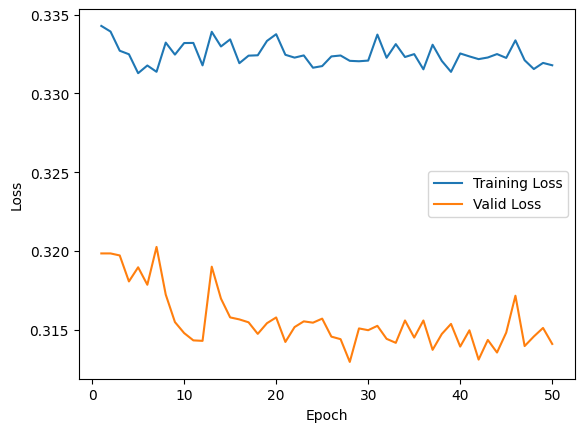

In [ ]:
plot_error(vgg_train_losses, vgg_val_losses)

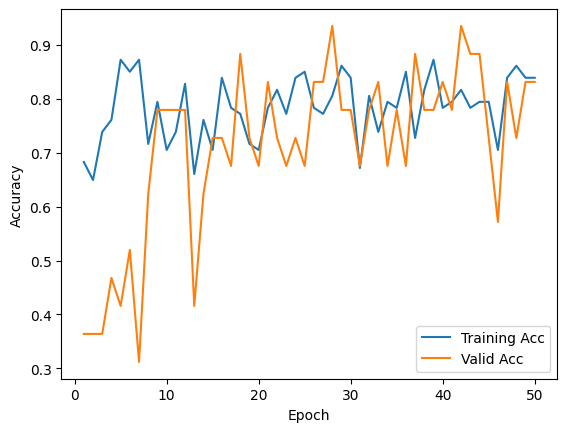

In [ ]:
plot_acc(vgg_train_acc, vgg_val_acc)

In [60]:
precision, recall, f1 = test(model, 'best_vgg.pth', test_loader, device)
print(f"Test: Precision: {np.round(precision, 4)}  Recall: {np.round(recall, 4)}  F1-Score: {np.round(f1, 4)}")

Test: Precision: 0.6931  Recall: 0.6926  F1-Score: 0.6846


In [69]:
precision, recall, f1 = test(model, 'best_vgg.pth', train_loader, device)
print(f"Training: Precision: {np.round(precision, 4)}  Recall: {np.round(recall, 4)}  F1-Score: {np.round(f1, 4)}")

Training: Precision: 0.8912  Recall: 0.8756  F1-Score: 0.8903


EfficientNet B0

In [45]:
efficientnet = EfficientNetModel(num_classes=20)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(efficientnet.parameters(), lr=LR)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efn_train_losses, efn_val_losses, efn_train_acc, efn_val_acc = train(
    model=efficientnet,
    epochs=EPOCH,
    device=device,
    train_dataloader=train_loader,
    valid_dataloader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    model_name='efficientnet',
)

100%|██████████| 13/13 [00:18<00:00,  1.41s/it]


Epoch 1  Loss: 2.5633185483684127 Accuracy: 0.2658


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Validation Accuracy: 0.5593 Loss: 1.437119381378035  Best Loss: 1.437119381378035


100%|██████████| 13/13 [00:17<00:00,  1.35s/it]


Epoch 2  Loss: 1.4485157209644088 Accuracy: 0.5947


100%|██████████| 3/3 [00:02<00:00,  1.01it/s]


Validation Accuracy: 0.6554 Loss: 1.0192695146995059  Best Loss: 1.0192695146995059


100%|██████████| 13/13 [00:18<00:00,  1.45s/it]


Epoch 3  Loss: 0.9030315583659265 Accuracy: 0.7342


100%|██████████| 3/3 [00:03<00:00,  1.01s/it]


Validation Accuracy: 0.6497 Loss: 1.2936187847547609  Best Loss: 1.0192695146995059


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 4  Loss: 0.8405821287797939 Accuracy: 0.7464


100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Validation Accuracy: 0.6554 Loss: 1.2612990308821244  Best Loss: 1.0192695146995059


100%|██████████| 13/13 [00:18<00:00,  1.42s/it]


Epoch 5  Loss: 0.7096932523551629 Accuracy: 0.7937


100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


Validation Accuracy: 0.6328 Loss: 1.1667380171594985  Best Loss: 1.0192695146995059


100%|██████████| 13/13 [00:17<00:00,  1.34s/it]


Epoch 6  Loss: 0.7279036764302611 Accuracy: 0.7816


100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


Validation Accuracy: 0.7684 Loss: 0.8795919772187283  Best Loss: 0.8795919772187283


100%|██████████| 13/13 [00:17<00:00,  1.38s/it]


Epoch 7  Loss: 0.6370741071675503 Accuracy: 0.7973


100%|██████████| 3/3 [00:03<00:00,  1.02s/it]


Validation Accuracy: 0.7119 Loss: 1.0185544201533612  Best Loss: 0.8795919772187283


100%|██████████| 13/13 [00:17<00:00,  1.38s/it]


Epoch 8  Loss: 0.6011335358207428 Accuracy: 0.807


100%|██████████| 3/3 [00:03<00:00,  1.28s/it]


Validation Accuracy: 0.7006 Loss: 1.017145341584901  Best Loss: 0.8795919772187283


100%|██████████| 13/13 [00:17<00:00,  1.37s/it]


Epoch 9  Loss: 0.5276824894358578 Accuracy: 0.841


100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


Validation Accuracy: 0.7401 Loss: 0.9642142359829808  Best Loss: 0.8795919772187283


100%|██████████| 13/13 [00:17<00:00,  1.37s/it]


Epoch 10  Loss: 0.5341516023815444 Accuracy: 0.8447


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


Validation Accuracy: 0.7119 Loss: 1.032547708599077  Best Loss: 0.8795919772187283


100%|██████████| 13/13 [00:17<00:00,  1.34s/it]


Epoch 11  Loss: 0.5322788637288485 Accuracy: 0.8422


100%|██████████| 13/13 [00:18<00:00,  1.40s/it]


Epoch 12  Loss: 0.49411023205325477 Accuracy: 0.8434


100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Validation Accuracy: 0.7175 Loss: 1.0267687361059021  Best Loss: 0.8795919772187283


100%|██████████| 13/13 [00:17<00:00,  1.34s/it]


Epoch 13  Loss: 0.47520244758823893 Accuracy: 0.8544


100%|██████████| 3/3 [00:03<00:00,  1.01s/it]


Validation Accuracy: 0.7571 Loss: 0.9147181192161821  Best Loss: 0.8795919772187283


100%|██████████| 13/13 [00:18<00:00,  1.45s/it]


Epoch 14  Loss: 0.47968360924204434 Accuracy: 0.8532


100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


Validation Accuracy: 0.7853 Loss: 0.8967285611194716  Best Loss: 0.8795919772187283


100%|██████████| 13/13 [00:20<00:00,  1.55s/it]


Epoch 15  Loss: 0.4652553661550053 Accuracy: 0.8617


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Validation Accuracy: 0.7175 Loss: 0.9390237253604338  Best Loss: 0.8795919772187283


100%|██████████| 13/13 [00:23<00:00,  1.77s/it]


Epoch 16  Loss: 0.4746280256282524 Accuracy: 0.8507


100%|██████████| 3/3 [00:03<00:00,  1.29s/it]


Validation Accuracy: 0.7797 Loss: 0.8806272667614756  Best Loss: 0.8795919772187283


100%|██████████| 13/13 [00:19<00:00,  1.51s/it]


Epoch 17  Loss: 0.49425019196069603 Accuracy: 0.8495


100%|██████████| 3/3 [00:03<00:00,  1.30s/it]


Validation Accuracy: 0.7571 Loss: 0.90327331458359  Best Loss: 0.8795919772187283


100%|██████████| 13/13 [00:23<00:00,  1.84s/it]


Epoch 18  Loss: 0.43103163792119875 Accuracy: 0.8726


100%|██████████| 3/3 [00:03<00:00,  1.01s/it]


Validation Accuracy: 0.7458 Loss: 0.8979722167726707  Best Loss: 0.8795919772187283


100%|██████████| 13/13 [00:19<00:00,  1.50s/it]


Epoch 19  Loss: 0.4169103358671117 Accuracy: 0.8774


100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


Validation Accuracy: 0.7514 Loss: 0.8077323712548478  Best Loss: 0.8077323712548478


100%|██████████| 13/13 [00:22<00:00,  1.72s/it]


Epoch 20  Loss: 0.41109964924423703 Accuracy: 0.8738


100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


Validation Accuracy: 0.7853 Loss: 0.8060218361876047  Best Loss: 0.8060218361876047


100%|██████████| 13/13 [00:19<00:00,  1.52s/it]


Epoch 21  Loss: 0.38969848464230544 Accuracy: 0.8701


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


Validation Accuracy: 0.7288 Loss: 0.9533396194766807  Best Loss: 0.8060218361876047


100%|██████████| 13/13 [00:20<00:00,  1.58s/it]


Epoch 22  Loss: 0.32836903896020436 Accuracy: 0.9066


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Validation Accuracy: 0.7571 Loss: 0.9005099023811606  Best Loss: 0.8060218361876047


100%|██████████| 13/13 [00:21<00:00,  1.63s/it]


Epoch 23  Loss: 0.4222211174538894 Accuracy: 0.8714


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


Validation Accuracy: 0.8192 Loss: 0.753612444695524  Best Loss: 0.753612444695524


100%|██████████| 13/13 [00:18<00:00,  1.43s/it]


Epoch 24  Loss: 0.3717167570272269 Accuracy: 0.875


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Validation Accuracy: 0.7345 Loss: 0.9479070711788719  Best Loss: 0.753612444695524


100%|██████████| 13/13 [00:17<00:00,  1.35s/it]


Epoch 25  Loss: 0.3325471664128047 Accuracy: 0.8944


100%|██████████| 3/3 [00:02<00:00,  1.02it/s]


Validation Accuracy: 0.7571 Loss: 0.8477166640362079  Best Loss: 0.753612444695524


100%|██████████| 13/13 [00:20<00:00,  1.54s/it]


Epoch 26  Loss: 0.4026397388039664 Accuracy: 0.8786


100%|██████████| 3/3 [00:03<00:00,  1.00s/it]


Validation Accuracy: 0.7232 Loss: 1.1126196593311732  Best Loss: 0.753612444695524


100%|██████████| 13/13 [00:18<00:00,  1.41s/it]


Epoch 27  Loss: 0.3794436256090877 Accuracy: 0.8799


100%|██████████| 3/3 [00:03<00:00,  1.13s/it]


Validation Accuracy: 0.7797 Loss: 0.8852629441145199  Best Loss: 0.753612444695524


100%|██████████| 13/13 [00:18<00:00,  1.39s/it]


Epoch 28  Loss: 0.40085861519815796 Accuracy: 0.8908


100%|██████████| 13/13 [00:18<00:00,  1.40s/it]


Epoch 29  Loss: 0.3893559895411638 Accuracy: 0.8786


100%|██████████| 3/3 [00:03<00:00,  1.31s/it]


Validation Accuracy: 0.7401 Loss: 0.9423827329157447  Best Loss: 0.753612444695524


100%|██████████| 13/13 [00:17<00:00,  1.38s/it]


Epoch 30  Loss: 0.34925358371402176 Accuracy: 0.9005


100%|██████████| 3/3 [00:03<00:00,  1.02s/it]


Validation Accuracy: 0.7853 Loss: 0.938259357931547  Best Loss: 0.753612444695524


100%|██████████| 13/13 [00:18<00:00,  1.45s/it]


Epoch 31  Loss: 0.3262560791120053 Accuracy: 0.9017


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Validation Accuracy: 0.7571 Loss: 1.0073430635107814  Best Loss: 0.753612444695524


100%|██████████| 13/13 [00:17<00:00,  1.36s/it]


Epoch 32  Loss: 0.3186412734361126 Accuracy: 0.8944


100%|██████████| 3/3 [00:02<00:00,  1.01it/s]


Validation Accuracy: 0.7119 Loss: 1.2189121499465747  Best Loss: 0.753612444695524


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 33  Loss: 0.32799600218210945 Accuracy: 0.9053


100%|██████████| 3/3 [00:03<00:00,  1.01s/it]


Validation Accuracy: 0.7571 Loss: 0.978527852702236  Best Loss: 0.753612444695524


100%|██████████| 13/13 [00:17<00:00,  1.35s/it]


Epoch 34  Loss: 0.25815926701436737 Accuracy: 0.9102


100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


Validation Accuracy: 0.7401 Loss: 0.8960083670561616  Best Loss: 0.753612444695524


100%|██████████| 13/13 [00:18<00:00,  1.42s/it]


Epoch 35  Loss: 0.333010495678735 Accuracy: 0.8908


100%|██████████| 3/3 [00:02<00:00,  1.01it/s]


Validation Accuracy: 0.7458 Loss: 0.9040039506720557  Best Loss: 0.753612444695524


100%|██████████| 13/13 [00:17<00:00,  1.36s/it]


Epoch 36  Loss: 0.3684444173551777 Accuracy: 0.8847


100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


Validation Accuracy: 0.774 Loss: 0.8454416880759533  Best Loss: 0.753612444695524


100%|██████████| 13/13 [00:18<00:00,  1.40s/it]


Epoch 37  Loss: 0.37455579490707847 Accuracy: 0.8968


100%|██████████| 3/3 [00:03<00:00,  1.01s/it]


Validation Accuracy: 0.774 Loss: 0.9524552299130663  Best Loss: 0.753612444695524


100%|██████████| 13/13 [00:17<00:00,  1.34s/it]


Epoch 38  Loss: 0.3636927245261648 Accuracy: 0.8908


100%|██████████| 3/3 [00:03<00:00,  1.31s/it]


Validation Accuracy: 0.7571 Loss: 0.8708524254649223  Best Loss: 0.753612444695524


100%|██████████| 13/13 [00:17<00:00,  1.36s/it]


Epoch 39  Loss: 0.38800123303771267 Accuracy: 0.8823


100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


Validation Accuracy: 0.7514 Loss: 0.9082032994254824  Best Loss: 0.753612444695524


100%|██████████| 13/13 [00:17<00:00,  1.38s/it]


Epoch 40  Loss: 0.3284645221184378 Accuracy: 0.8968


100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


Validation Accuracy: 0.7627 Loss: 1.109701981022349  Best Loss: 0.753612444695524


100%|██████████| 13/13 [00:17<00:00,  1.35s/it]


Epoch 41  Loss: 0.303228637121564 Accuracy: 0.8956


100%|██████████| 3/3 [00:03<00:00,  1.01s/it]


Validation Accuracy: 0.7797 Loss: 0.8510332015394617  Best Loss: 0.753612444695524


100%|██████████| 13/13 [00:18<00:00,  1.40s/it]


Epoch 42  Loss: 0.3327198840498125 Accuracy: 0.8896


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Validation Accuracy: 0.7853 Loss: 0.7575511763850433  Best Loss: 0.753612444695524


100%|██████████| 13/13 [00:17<00:00,  1.35s/it]


Epoch 43  Loss: 0.3316986585461406 Accuracy: 0.8993


100%|██████████| 3/3 [00:03<00:00,  1.00s/it]


Validation Accuracy: 0.7458 Loss: 0.8774296329370911  Best Loss: 0.753612444695524


100%|██████████| 13/13 [00:18<00:00,  1.43s/it]


Epoch 44  Loss: 0.3095807756038994 Accuracy: 0.9066


100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


Validation Accuracy: 0.7684 Loss: 0.9158922671063324  Best Loss: 0.753612444695524


100%|██████████| 13/13 [00:17<00:00,  1.34s/it]


Epoch 45  Loss: 0.27151489895732317 Accuracy: 0.909


100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


Validation Accuracy: 0.7401 Loss: 0.913434622380421  Best Loss: 0.753612444695524


100%|██████████| 13/13 [00:18<00:00,  1.41s/it]


Epoch 46  Loss: 0.3186737430479812 Accuracy: 0.9066


100%|██████████| 3/3 [00:02<00:00,  1.00it/s]


Validation Accuracy: 0.7232 Loss: 1.040615454657665  Best Loss: 0.753612444695524


100%|██████████| 13/13 [00:17<00:00,  1.35s/it]


Epoch 47  Loss: 0.30798116612323756 Accuracy: 0.9066


100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


Validation Accuracy: 0.7684 Loss: 0.8726488245362819  Best Loss: 0.753612444695524


100%|██████████| 13/13 [00:17<00:00,  1.38s/it]


Epoch 48  Loss: 0.3066682473404493 Accuracy: 0.9041


100%|██████████| 3/3 [00:03<00:00,  1.00s/it]


Validation Accuracy: 0.7401 Loss: 0.9907847650986684  Best Loss: 0.753612444695524


100%|██████████| 13/13 [00:17<00:00,  1.36s/it]


Epoch 49  Loss: 0.3016015726457475 Accuracy: 0.9078


100%|██████████| 3/3 [00:03<00:00,  1.29s/it]


Validation Accuracy: 0.7119 Loss: 1.0804839516156406  Best Loss: 0.753612444695524


100%|██████████| 13/13 [00:17<00:00,  1.34s/it]


Epoch 50  Loss: 0.26063846800554646 Accuracy: 0.9211


100%|██████████| 3/3 [00:03<00:00,  1.00s/it]

Validation Accuracy: 0.7571 Loss: 0.9073804938604039  Best Loss: 0.753612444695524


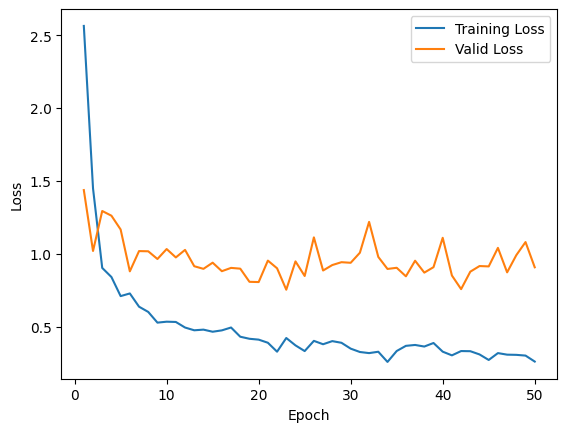

In [46]:
plot_error(efn_train_losses, efn_val_losses)

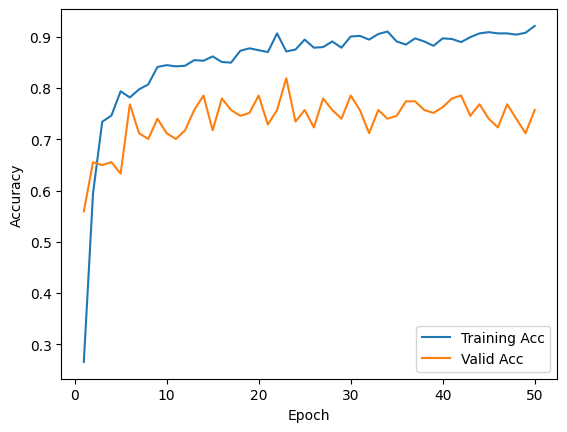

In [47]:
plot_acc(efn_train_acc, efn_val_acc)

In [65]:
precision, recall, f1 = test(efficientnet, 'best_efficientnet.pth', test_loader, device)
print(f"Test: Precision: {np.round(precision, 4)}  Recall: {np.round(recall, 4)}  F1-Score: {np.round(f1, 4)}")

Test: Precision: 0.735  Recall: 0.7391  F1-Score: 0.7311


In [66]:
precision, recall, f1 = test(efficientnet, 'best_efficientnet.pth', train_loader, device)
print(f"Training: Precision: {np.round(precision, 4)}  Recall: {np.round(recall, 4)}  F1-Score: {np.round(f1, 4)}")

Training: Precision: 0.9427  Recall: 0.9392  F1-Score: 0.9404
